In [1]:
#%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import torch.utils.data as data_utils

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from IPython import display

# 1. Вспомогательные функции

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) 

In [5]:
class Atan(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.atan(x)

## 1.1 Стандартная эпоха обучения

In [6]:
def epoch(loader, model, device, opt=None):
    """Standard training/evaluation epoch over the dataset"""

    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

## 1.2 Bound propagation

In [7]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    bounds.append(initial_bound)
    list_of_layers = list(model.children())
    
    for i in range(len(list_of_layers)):
        layer = list_of_layers[i]
        
        # Очевидный переход
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)

        # Переход через линейный слой
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()

        # Переход через свёрточный слой
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])

        # Переход через ReLU
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
        
        # Переход через Sigmoid
        elif isinstance(layer, nn.Sigmoid):
            l_ = l.sigmoid()
            u_ = u.sigmoid()
        
        # Переход через Tanh
        elif isinstance(layer, nn.Tanh):
            l_ = l.tanh()
            u_ = u.tanh()
        
        # Переход через LeakyReLU
        elif isinstance(layer, nn.LeakyReLU):
            l_ = layer(l)
            u_ = layer(u)
        
        # Переход через ATAN
        elif isinstance(layer, Atan):
            l_ = layer(l)
            u_ = layer(u)
            
        else:
            print(layer)
            raise "Bad layer"
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

## 1.3 Переход через последний линейный слой

In [8]:
def interval_based_bound(model, c, bounds, idx):
    # requires last layer to be linear
    cW = c.t() @ model.last_linear.weight
    cb = c.t() @ model.last_linear.bias
    
    l,u = bounds[-2]
    return (cW.clamp(min=0) @ l[idx].t() + cW.clamp(max=0) @ u[idx].t() + cb[:,None]).t()

## 1.4 Эпоха сертификационного обучения

In [9]:
def epoch_robust_bound(loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse=False, opt=None):
    robust_err = 0
    total_robust_loss = 0
    total_mse_loss = 0
    total_ibp_loss = 0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1
    
    for i, data in enumerate(loader,0):   
        mse_loss_list = []
        lower_bounds = []
        upper_bounds = []
        
        X, y = data
        X, y = X.to(device), y.to(device)
        
        ###### fit loss calculation ######
        yp = model(X)
        fit_loss = nn.CrossEntropyLoss()(yp,y)
    
        ###### robust loss calculation ######
        initial_bound = (X - epsilon_schedule[batch_counter], X + epsilon_schedule[batch_counter])
        bounds = bound_propagation(model, initial_bound)
        robust_loss = 0
        
        # итерируемся по всем возможным классам
        for y0 in range(10):
            # Если в данном батче есть изображения этого класса
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)
                
                # See https://discuss.pytorch.org/t/loss-reduction-sum-vs-mean-when-to-use-each/115641
                robust_loss += nn.CrossEntropyLoss(reduction='sum')(-lower_bound, y[y==y0]) / X.shape[0]
                
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item() #increment when true label is not winning       
        
        total_robust_loss += robust_loss.item() * X.shape[0]  
        
        ##### MSE Loss #####
        # ~ Loss соответствующий регуляризации \\z_max - z_min||
        indices_of_layers = [2,4,7,8] #CNN_small
        
        for i in range(len(indices_of_layers)):
            lower_bounds.append(Flatten()(bounds[indices_of_layers[i]][0])) #lower bounds 
            upper_bounds.append(Flatten()(bounds[indices_of_layers[i]][1])) #upper bounds 
            mse_loss_list.append(nn.MSELoss()(lower_bounds[i], upper_bounds[i]))
        
        mse_loss = mse_loss_list[0] + mse_loss_list[1] + mse_loss_list[2] #+ mse_loss_list[3] + mse_loss_list[4] + mse_loss_list[5] + mse_loss_list[6]
        total_mse_loss += mse_loss.item()
        
        ###### combined losss ######
        # ~ Собираем общий лосс
        ibp_loss = kappa_schedule[batch_counter]*fit_loss + (1-kappa_schedule[batch_counter])*robust_loss
        
        if (mse==True):
            combined_loss =  ibp_loss + mse_loss
        else:
            combined_loss =  ibp_loss

        total_ibp_loss += ibp_loss.item()
        
        batch_counter +=1
         
        if opt:
            opt.zero_grad()
            combined_loss.backward()
            opt.step()
        
    return robust_err / len(loader.dataset), total_ibp_loss / len(loader.dataset), total_mse_loss/ len(loader.dataset)

## 1.5 Вычисление робастной ошибки

In [10]:
def epoch_calculate_robust_err (loader, model, epsilon, device):
    robust_err = 0.0
    
    C = [-torch.eye(10).to(device) for _ in range(10)]
    for y0 in range(10):
        C[y0][y0,:] += 1


    for X,y in loader:
        X,y = X.to(device), y.to(device)
        
        initial_bound = (X - epsilon, X + epsilon)
        bounds = bound_propagation(model, initial_bound)

        for y0 in range(10):
            if sum(y==y0) > 0:
                lower_bound = interval_based_bound(model, C[y0], bounds, y==y0)                
                robust_err += (lower_bound.min(dim=1)[0] < 0).sum().item() #increment when true label is not winning       
        
    return robust_err / len(loader.dataset)

## 1.6 Вспомогательные функции для более стабильного сертификационного обучения

In [11]:
def generate_kappa_schedule_MNIST():
    kappa_schedule = 2000*[1] # warm-up phase
    kappa_value = 1.0
    step = 0.5/58000
    
    for i in range(58000):
        kappa_value = kappa_value - step
        kappa_schedule.append(kappa_value)
    
    return kappa_schedule


def generate_epsilon_schedule_MNIST(epsilon_train):
    epsilon_schedule = []
    step = epsilon_train/10000
            
    for i in range(10000):
        epsilon_schedule.append(i*step) #ramp-up phase
    
    for i in range(50000):
        epsilon_schedule.append(epsilon_train)
        
    return epsilon_schedule

# 2. Датасет

In [12]:
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

# 3. Обучение ИНС с разными функциями активации

## 3.1 ReLU

In [13]:
class CNN_small_relu(torch.nn.Module):
    def __init__(self):
        super(CNN_small_relu, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.relu2 = nn.ReLU()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.relu3 = nn.ReLU()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.relu3(x)

        out = self.last_linear(x)
        
        return out

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [15]:
device

device(type='cuda', index=0)

In [85]:
mse = False # Не будем использовать регуляризацию \\z_max - z_min\\
model = CNN_small_relu().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [86]:
model

CNN_small_relu(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (relu2): ReLU()
  (flat): Flatten()
  (linear1): Linear(in_features=3200, out_features=100, bias=True)
  (relu3): ReLU()
  (last_linear): Linear(in_features=100, out_features=10, bias=True)
)

In [124]:
EPSILON = 0.1
EPSILON_TRAIN = 0.2
kappa_schedule = generate_kappa_schedule_MNIST()

epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
    epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
    epsilon_schedule.append(EPSILON_TRAIN)

batch_counter = 0

In [125]:
verified_err_array = []
test_err_arr = []

for t in range(50):
    robust_err, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
    
    batch_counter += 600
    verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
    test_err,_ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(robust_err, ibp_loss, mse_loss)
    print(test_err, verified)
    print("----------------------")

    test_err_arr.append(test_err)
    verified_err_array.append(verified)

epoch:  0
0.9507333333333333 0.0023321935885120184 1.127422892425845
0.0198 1.0
----------------------
epoch:  1
1.0 0.0006156399107538164 10.22486056213379
0.0152 1.0
----------------------
epoch:  2
1.0 0.00041207593902557467 39.95208684488932
0.0111 1.0
----------------------
epoch:  3
1.0 0.001155717500630999 37.282453195953366
0.0175 1.0
----------------------
epoch:  4
0.9994833333333333 0.0014645089976489543 0.3353128650824229
0.0218 0.7348
----------------------
epoch:  5
0.8800666666666667 0.0012858557388186454 0.12726402382850646
0.023 0.2529
----------------------
epoch:  6
0.6465166666666666 0.0011679169724384943 0.08980579821268718
0.0214 0.1387
----------------------
epoch:  7
0.46145 0.0010193889416443805 0.07100821478366852
0.018 0.1
----------------------
epoch:  8
0.34865 0.0009028206259012223 0.0622368601957957
0.0169 0.0877
----------------------
epoch:  9
0.2925833333333333 0.0008462894476018846 0.060551467712720235
0.0173 0.079
----------------------
epoch:  10
0.

In [128]:
torch.save(model.state_dict(), "./results/CNN_small_relu_without_regularization")

In [129]:
with open("./results/Errors_CNN_small_relu_without_regularization.txt", "w") as file:
    file.write(" ".join([str(i) for i in test_err_arr]) + "\n")
    file.write(" ".join([str(i) for i in verified_err_array]) + "\n")

## 3.2 Sigmoid

In [16]:
class CNN_small_sigmoid(torch.nn.Module):
    def __init__(self):

        super(CNN_small_sigmoid, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.sigmoid1 = nn.Sigmoid()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.sigmoid2 = nn.Sigmoid()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.sigmoid3 = nn.Sigmoid()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.sigmoid1(x)
        
        x = self.conv2(x)
        x = self.sigmoid2(x)
        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.sigmoid3(x)

        out = self.last_linear(x)
        
        return out

In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

model = CNN_small_sigmoid().to(device)

In [139]:
EPSILON = 0.1
EPSILON_TRAIN = 0.2
kappa_schedule = generate_kappa_schedule_MNIST()

epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
    epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
    epsilon_schedule.append(EPSILON_TRAIN)

In [140]:
mse = False # Не будем использовать регуляризацию \\z_max - z_min\\
model = CNN_small_sigmoid().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [141]:
batch_counter = 0

In [142]:
verified_err_array = []
test_err_arr = []

for t in range(50):
    robust_err, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
    
    batch_counter += 600
    verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
    test_err,_ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(robust_err, ibp_loss, mse_loss)
    print(test_err, verified)
    print("----------------------")

    test_err_arr.append(test_err)
    verified_err_array.append(verified)

epoch:  0
0.7858833333333334 0.00862096435079972 0.0025573673273137114
0.0714 1.0
----------------------
epoch:  1
0.9986833333333334 0.001917631433904171 0.009987449142336846
0.0387 1.0
----------------------
epoch:  2
1.0 0.0011175427180404463 0.012668585064013799
0.0276 1.0
----------------------
epoch:  3
1.0 0.001009822978855421 0.014343986825148265
0.0204 1.0
----------------------
epoch:  4
1.0 0.0017000300927708545 0.0158971206287543
0.0163 1.0
----------------------
epoch:  5
1.0 0.0022814177145560584 0.017471284224589666
0.0166 1.0
----------------------
epoch:  6
1.0 0.0026935902275145055 0.019111238425970078
0.0174 1.0
----------------------
epoch:  7
1.0 0.003031615090618531 0.019928620008627572
0.0166 1.0
----------------------
epoch:  8
1.0 0.003342772268255552 0.020380749201774597
0.0172 1.0
----------------------
epoch:  9
1.0 0.003655465866625309 0.020760627591609956
0.0148 1.0
----------------------
epoch:  10
1.0 0.003966992005705833 0.021084256398677826
0.0146 1.0


In [143]:
torch.save(model.state_dict(), "./results/CNN_small_sigmoid_without_regularization")

In [144]:
with open("./results/Errors_CNN_small_sigmoid_without_regularization.txt", "w") as file:
    file.write(" ".join([str(i) for i in test_err_arr]) + "\n")
    file.write(" ".join([str(i) for i in verified_err_array]) + "\n")

А теперь с регуляризацией:

In [20]:
EPSILON = 0.1
EPSILON_TRAIN = 0.2
kappa_schedule = generate_kappa_schedule_MNIST()

epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
    epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
    epsilon_schedule.append(EPSILON_TRAIN)

batch_counter = 0

mse = True
model = CNN_small_sigmoid().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [156]:
verified_err_array = []
test_err_arr = []

for t in range(50):
    robust_err, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
    
    batch_counter += 600
    verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
    test_err,_ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(robust_err, ibp_loss, mse_loss)
    print(test_err, verified)
    print("----------------------")

    test_err_arr.append(test_err)
    verified_err_array.append(verified)

epoch:  0
0.58035 0.008637083803613981 0.0008136168081973783
0.0904 0.9987
----------------------
epoch:  1
0.5717333333333333 0.002932092366864284 0.0013823169526954492
0.0735 0.9124
----------------------
epoch:  2
0.6346833333333334 0.0023872093450278044 0.0015639120099445185
0.056 0.75
----------------------
epoch:  3
0.6978 0.002140245157231887 0.0016957161304851373
0.0505 0.5301
----------------------
epoch:  4
0.72255 0.0021447194115569194 0.001760336996614933
0.052 0.3734
----------------------
epoch:  5
0.73285 0.0022832596944024164 0.0018095975269873936
0.0473 0.2779
----------------------
epoch:  6
0.72225 0.002428988336523374 0.0018077236726880073
0.0524 0.2264
----------------------
epoch:  7
0.6286 0.0023849984572579465 0.001577745380749305
0.05 0.1933
----------------------
epoch:  8
0.5374 0.0022886600856979688 0.0013947904421637456
0.0469 0.1614
----------------------
epoch:  9
0.4661666666666667 0.0021971735518425705 0.0012716096373895805
0.0449 0.146
----------------

In [157]:
torch.save(model.state_dict(), "./results/CNN_small_sigmoid_with_regularization")

In [158]:
with open("./results/Errors_CNN_small_sigmoid_with_regularization.txt", "w") as file:
    file.write(" ".join([str(i) for i in test_err_arr]) + "\n")
    file.write(" ".join([str(i) for i in verified_err_array]) + "\n")

## 3.3 Tanh

In [17]:
class CNN_small_tanh(torch.nn.Module):
    def __init__(self):

        super(CNN_small_tanh, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.tanh2 = nn.Tanh()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.tanh3 = nn.Tanh()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        
        x = self.conv2(x)
        x = self.tanh2(x)
        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.tanh3(x)

        out = self.last_linear(x)
        
        return out

In [32]:
EPSILON = 0.1
EPSILON_TRAIN = 0.2
kappa_schedule = generate_kappa_schedule_MNIST()

epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
    epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
    epsilon_schedule.append(EPSILON_TRAIN)

batch_counter = 0

mse = True
model = CNN_small_tanh().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [33]:
verified_err_array = []
test_err_arr = []

for t in range(50):
    robust_err, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
    
    batch_counter += 600
    verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
    test_err,_ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(robust_err, ibp_loss, mse_loss)
    print(test_err, verified)
    print("----------------------")

    test_err_arr.append(test_err)
    verified_err_array.append(verified)

epoch:  0
0.26205 0.0032645151288559038 0.0016163148131687194
0.0624 0.9461
----------------------
epoch:  1
0.24218333333333333 0.0019905956904093425 0.001237370226532221
0.0455 0.4851
----------------------
epoch:  2
0.23963333333333334 0.0016091171444704135 0.0013114718069632849
0.0397 0.2819
----------------------
epoch:  3
0.2624666666666667 0.0014735752997919918 0.0014531073424965144
0.0386 0.2092
----------------------
epoch:  4
0.292 0.0014778237561384837 0.0016194859519600869
0.0384 0.1604
----------------------
epoch:  5
0.32645 0.0015364312617729109 0.0017511019855737686
0.0388 0.1437
----------------------
epoch:  6
0.3558 0.0016597275206198295 0.0018415049043794473
0.0424 0.136
----------------------
epoch:  7
0.3275 0.0016541083904604117 0.0016667520947754382
0.0371 0.1111
----------------------
epoch:  8
0.29846666666666666 0.0016204642128199338 0.001498687579234441
0.0422 0.1141
----------------------
epoch:  9
0.27525 0.0015996955855439106 0.0014080404654145241
0.038 0

In [34]:
torch.save(model.state_dict(), "./results/CNN_small_tanh_with_regularization")

In [35]:
with open("./results/Errors_CNN_small_tanh_with_regularization.txt", "w") as file:
    file.write(" ".join([str(i) for i in test_err_arr]) + "\n")
    file.write(" ".join([str(i) for i in verified_err_array]) + "\n")

## 3.4 ARCTAN

In [18]:
class CNN_small_atan(torch.nn.Module):
    def __init__(self):

        super(CNN_small_atan, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.atan1 = Atan()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.atan2 = Atan()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.atan3 = Atan()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):    
        x = self.conv1(x)
        x = self.atan1(x)
        
        x = self.conv2(x)
        x = self.atan2(x)
        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.atan3(x)

        out = self.last_linear(x)
        
        return out

In [44]:
EPSILON = 0.1
EPSILON_TRAIN = 0.2
kappa_schedule = generate_kappa_schedule_MNIST()

epsilon_schedule = []
step = EPSILON_TRAIN/4000
            
for i in range(4000):
    epsilon_schedule.append(i*step) #ramp-up phase
for i in range(56000):
    epsilon_schedule.append(EPSILON_TRAIN)

batch_counter = 0

mse = True
model = CNN_small_atan().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [45]:
verified_err_array = []
test_err_arr = []

for t in range(50):
    robust_err, ibp_loss, mse_loss = epoch_robust_bound(train_loader, model, epsilon_schedule, device, kappa_schedule, batch_counter, mse, opt)
    
    batch_counter += 600
    verified = epoch_calculate_robust_err(test_loader, model, EPSILON, device)
    test_err,_ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(robust_err, ibp_loss, mse_loss)
    print(test_err, verified)
    print("----------------------")

    test_err_arr.append(test_err)
    verified_err_array.append(verified)

epoch:  0
0.29275 0.0033715099391837915 0.0015824636984926959
0.0673 0.9781
----------------------
epoch:  1
0.38708333333333333 0.0025854291119923193 0.0014533447459340095
0.0698 0.7288
----------------------
epoch:  2
0.3471166666666667 0.002232670915747682 0.0012787402210136254
0.0548 0.402
----------------------
epoch:  3
0.36288333333333334 0.0020962152710805337 0.00140902065820992
0.0543 0.272
----------------------
epoch:  4
0.3975666666666667 0.002094366693869233 0.0015980629943311215
0.0576 0.2316
----------------------
epoch:  5
0.4424166666666667 0.0021984494882325333 0.0018131042485435803
0.0558 0.2019
----------------------
epoch:  6
0.47913333333333336 0.002340110756581028 0.0019491364412009716
0.0532 0.1806
----------------------
epoch:  7
0.46308333333333335 0.0023659634227554 0.0018462724968791007
0.0551 0.1738
----------------------
epoch:  8
0.43645 0.002365278779591123 0.0017256349138915538
0.0511 0.1635
----------------------
epoch:  9
0.4105 0.0023697409766415753 

In [46]:
torch.save(model.state_dict(), "./results/CNN_small_atan_with_regularization")

In [47]:
with open("./results/Errors_CNN_small_atan_with_regularization.txt", "w") as file:
    file.write(" ".join([str(i) for i in test_err_arr]) + "\n")
    file.write(" ".join([str(i) for i in verified_err_array]) + "\n")

# 4. Эмпирическая оценка робастности полученных ИНС через PGD

Заметим, что даже такой сильный метод атаки как PGD с 200 шагами не может подобрать нужное возмущение для части изображений, для которых мы не смогли доказать локальную устойчивость сети. Скорее всего среди этих изображений есть часть, для которых в реальности сети локально устойчива, просто наш метод верификации не смог этого доказать.

In [38]:
from torchattacks import PGD

In [39]:
model = CNN_small_sigmoid().to(device)
model.load_state_dict(torch.load("./results/CNN_small_sigmoid_with_regularization"))

atk = PGD(model, eps=EPSILON, alpha=2/255, steps=200, random_start=True)

total_number = 0
number_of_successfully_attacked = 0

for i, data in enumerate(test_loader,0):
    x = data[0].to(device)
    y = data[1].to(device)
    
    adv_images = atk(x, y)
    model(adv_images)
    
    predictions = model(adv_images)
    for idx, prediction in enumerate(predictions):
        total_number += 1
        
        if not bool(y[idx] == prediction.argmax()):
            number_of_successfully_attacked += 1

print(total_number)
print(number_of_successfully_attacked)
print(epoch_calculate_robust_err(test_loader, model, EPSILON, device))

10000
537
0.0614


Наш метод не смог доказать локальную устойчивость сети для 10000 * 0.0614 = 614 изображений, а PGD смог подобрать атакующий шум только для 537 из них.

In [40]:
model = CNN_small_tanh().to(device)
model.load_state_dict(torch.load("./results/CNN_small_tanh_with_regularization"))

atk = PGD(model, eps=EPSILON, alpha=2/255, steps=200, random_start=True)

total_number = 0
number_of_successfully_attacked = 0

for i, data in enumerate(test_loader,0):
    x = data[0].to(device)
    y = data[1].to(device)
    
    adv_images = atk(x, y)
    model(adv_images)
    
    predictions = model(adv_images)
    for idx, prediction in enumerate(predictions):
        total_number += 1
        
        if not bool(y[idx] == prediction.argmax()):
            number_of_successfully_attacked += 1

print(total_number)
print(number_of_successfully_attacked)
print(epoch_calculate_robust_err(test_loader, model, EPSILON, device))

10000
587
0.0675


In [41]:
model = CNN_small_atan().to(device)
model.load_state_dict(torch.load("./results/CNN_small_atan_with_regularization"))

atk = PGD(model, eps=EPSILON, alpha=2/255, steps=200, random_start=True)

total_number = 0
number_of_successfully_attacked = 0

for i, data in enumerate(test_loader,0):
    x = data[0].to(device)
    y = data[1].to(device)
    
    adv_images = atk(x, y)
    model(adv_images)
    
    predictions = model(adv_images)
    for idx, prediction in enumerate(predictions):
        total_number += 1
        
        if not bool(y[idx] == prediction.argmax()):
            number_of_successfully_attacked += 1

print(total_number)
print(number_of_successfully_attacked)
print(epoch_calculate_robust_err(test_loader, model, EPSILON, device))

10000
786
0.0979


# 5. Графики

## 5.1 Успехи сертификационного обучения для не ReLU функций активации

In [65]:
with open("./results/Errors_CNN_small_relu_without_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    relu_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

with open("./results/Errors_CNN_small_sigmoid_without_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    sigmoid_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

epoch_list = [i for i in range(50)]

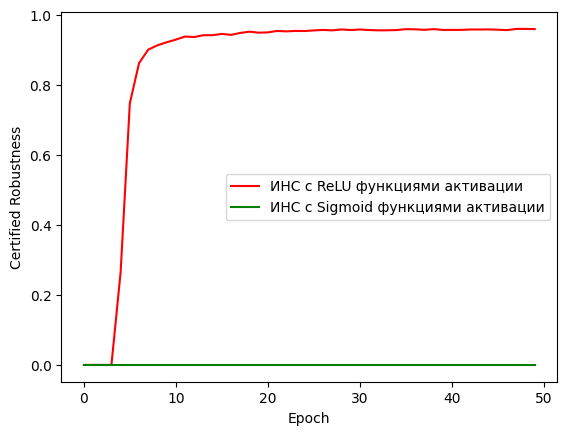

In [72]:
plt.plot(epoch_list, relu_certified_robustness, color='r', label='ИНС с ReLU функциями активации') 
plt.plot(epoch_list, sigmoid_certified_robustness, color='g', label='ИНС с Sigmoid функциями активации') 

plt.xlabel("Epoch") 
plt.ylabel("Certified Robustness")
  
plt.legend() 
  
plt.show() 

## 5.2 Certified Robustness для сертификационного обучения с регуляризацией

In [74]:
with open("./results/Errors_CNN_small_sigmoid_with_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    sigmoid_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

with open("./results/Errors_CNN_small_tanh_with_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    tanh_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

with open("./results/Errors_CNN_small_atan_with_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    atan_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

with open("./results/Errors_CNN_small_elu_with_regularization.txt", "r") as file:
    verified_err_line = file.read().splitlines()[1]
    elu_certified_robustness = [1 - float(s) for s in verified_err_line.split()]

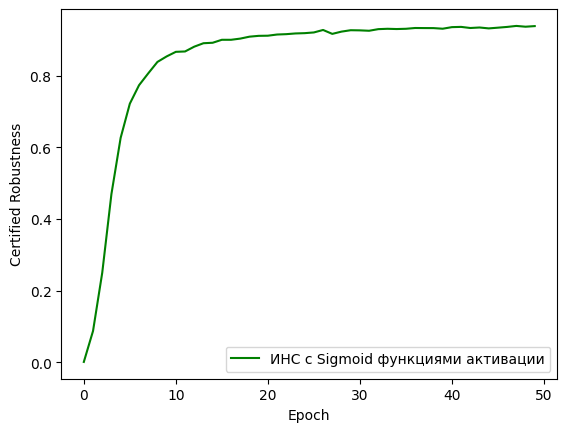

In [78]:
plt.plot(epoch_list, sigmoid_certified_robustness, color='g', label='ИНС с Sigmoid функциями активации') 

plt.xlabel("Epoch") 
plt.ylabel("Certified Robustness")
  
plt.legend() 
  
plt.show() 

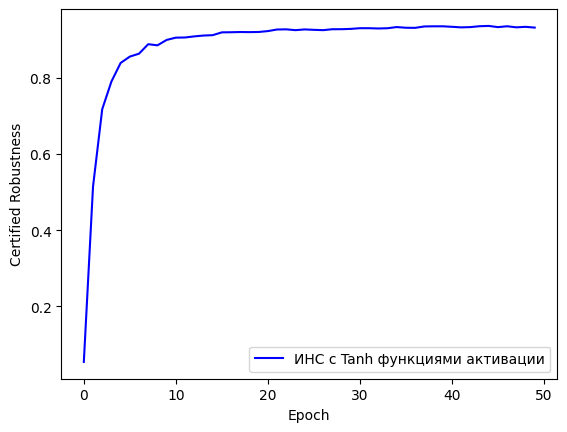

In [81]:
plt.plot(epoch_list, tanh_certified_robustness, color='b', label='ИНС с Tanh функциями активации') 

plt.xlabel("Epoch") 
plt.ylabel("Certified Robustness")
  
plt.legend() 
  
plt.show() 

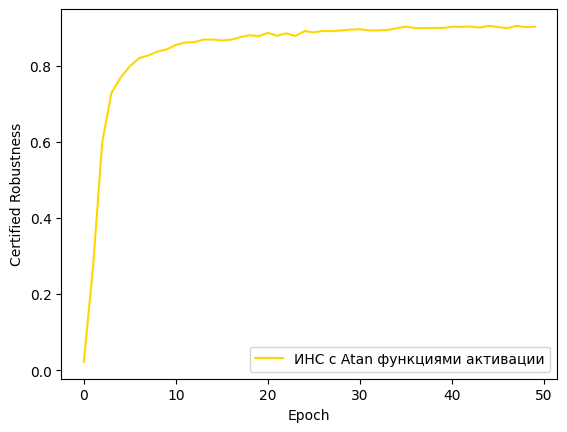

In [84]:
plt.plot(epoch_list, atan_certified_robustness, color='gold', label='ИНС с Atan функциями активации') 

plt.xlabel("Epoch") 
plt.ylabel("Certified Robustness")
  
plt.legend() 
  
plt.show() 

# 6. Оценка числа "мёртвых нейронов" в ReLU сети

In [112]:
class CNN_small_relu_dead_neuron(torch.nn.Module):
    def __init__(self):
        super(CNN_small_relu_dead_neuron, self).__init__()

        self._dead_neuron_number = 0
        self._total_neuron_number = 0
        
        self.conv1 = nn.Conv2d(1, 16, 4, padding=0, stride=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, 4, padding=0, stride=1)
        self.relu2 = nn.ReLU()
        self.flat = Flatten()
        self.linear1 = nn.Linear(32*10*10, 100)
        self.relu3 = nn.ReLU()
        self.last_linear = nn.Linear(100, 10)                
        
    def forward(self, x):        
        x = self.conv1(x)
        x = self.relu1(x)

        total = 1
        for i in x.shape:
            total *= i
        self._dead_neuron_number += total - int(x.count_nonzero())
        self._total_neuron_number += total
        
        x = self.conv2(x)
        x = self.relu2(x)

        total = 1
        for i in x.shape:
            total *= i
        self._dead_neuron_number += total - int(x.count_nonzero())
        self._total_neuron_number += total
        
        x = self.flat(x)
        x = self.linear1(x)
        x = self.relu3(x)

        total = 1
        for i in x.shape:
            total *= i
        self._dead_neuron_number += total - int(x.count_nonzero())
        self._total_neuron_number += total

        out = self.last_linear(x)
        
        return out

In [113]:
model = CNN_small_relu_dead_neuron().to(device)
model.load_state_dict(torch.load("./results/CNN_small_relu_without_regularization"))

<All keys matched successfully>

In [159]:
# Возьмём 100 случайных изображений

x = None
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=True)

for i, data in enumerate(test_loader,0):
    x = data[0].to(device)
    break

In [115]:
_ = model(x)

In [116]:
model._dead_neuron_number / model._total_neuron_number

0.8837524983344437

А для обычной процедуры обучения:

In [153]:
model = CNN_small_relu().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)

In [154]:
for t in range(3):
    epoch(train_loader, model, device, opt)
    test_err, _ = epoch(test_loader, model, device)
    
    print("epoch: ", t)
    print(test_err)
    print("----------------------")

epoch:  0
0.0217
----------------------
epoch:  1
0.0166
----------------------
epoch:  2
0.0123
----------------------


In [155]:
torch.save(model.state_dict(), "./results/CNN_small_relu_standard_train_procedure")

In [156]:
model = CNN_small_relu_dead_neuron().to(device)
model.load_state_dict(torch.load("./results/CNN_small_relu_standard_train_procedure"))

<All keys matched successfully>

In [157]:
_ = model(x)

In [158]:
model._dead_neuron_number / model._total_neuron_number

0.494417055296469

Число "мёртвых нейронов" в сети, полученной с помощью сертификационного обучения намного больше, чем у сети, полученной с помощью классической процедуры обучения.